In [13]:
# Add the parent directory to the path so that we can import the src module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [14]:
from src.camera import CameraCalibration, Camera, CameraPose
from src.camera.video import VideoStream
from src.segmentation.circledetector import CircleDetector
from src.segmentation.yolo_detector import SplitYoloDetector
from src.segmentation.split_image import ImageSplitter, crop_image_xy
from src.pose.position_estimation import PositionEstimation
from src.pose.velocity_regression import velocity_regression
from src.ukf import BallUKF
from src.ukf.measurement import PixelPositionMeasurementMode
from src.pingpong.ball import BallConstants
from src.pingpong.table import TableConstants
from src.fileutils import DATA_DIR, MODELS_DIR
import src.visualization.plot3D as plot3D

from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLOWorld
from scipy.spatial.transform import Rotation
from itertools import islice

In [15]:
# Define constants
CALIBRATION_VIDEO_PATH = DATA_DIR / 'calibration' / 'Priyanshu_iPhone13.MOV'
VIDEO_PATH = DATA_DIR / "videos" / "IMG_5385.MOV"

BALL = BallConstants()
TABLE = TableConstants()

CAMERA_POSITION = np.array([0, -(TABLE.net_width + 2), 0.5])
CAMERA_ORIENTATION = Rotation.from_euler('xyz', [-90, 0, 0], degrees=True)
CAMERA_MIRROR_Y = False


In [16]:
# Get camera calibration
calibration_video = VideoStream(DATA_DIR / 'calibration' / 'Priyanshu_iPhone13.MOV', frames_to_read=100)
print(calibration_video)
calibration = CameraCalibration.from_calibration_video(tqdm(calibration_video, total=calibration_video.get_length_if_known()))
calibration.intrinsic_matrix

VideoStream:
	Source: C:\Users\agpri\OneDrive\Documents\GitHub\PingPongTracking\data\calibration\Priyanshu_iPhone13.MOV
	FPS: 212.2765805331427
	Frames: 866
	Resolution: 1920x1080
	Frames to read: 100



100%|██████████| 100/100 [00:04<00:00, 24.05it/s]


array([[       1978,           0,      898.62],
       [          0,      3876.7,      549.85],
       [          0,           0,           1]])

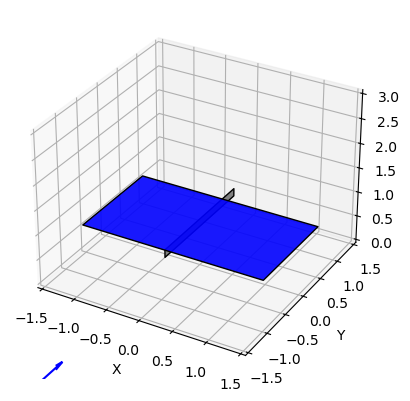

In [17]:
# Initialize camera
camera_pose = CameraPose(CAMERA_POSITION, CAMERA_ORIENTATION, mirror_y=CAMERA_MIRROR_Y)
camera = Camera(camera_pose, calibration)

# Plot the camera
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot3D.plot_table(ax, TABLE)
plot3D.plot_camera(ax, camera)

In [18]:

# Initialize position estimator and circle detector
position_estimator = PositionEstimation(camera, BALL, TABLE)
circle_detector = CircleDetector()

position_estimator.project_ball_position_table_reference_frame_to_camera_plane(np.array([0, -3, 1]))

(899, -1772, 95)

In [19]:
# Load video 
video = VideoStream(VIDEO_PATH)
dt = 1/video.fps
video

VideoStream:
	Source: C:\Users\agpri\OneDrive\Documents\GitHub\PingPongTracking\data\videos\IMG_5385.MOV
	FPS: 26.625
	Frames: 213
	Resolution: 1920x1080

In [20]:
# Init yolo
model = YOLOWorld(str(MODELS_DIR / 'yolov8l-world.pt'))
model.conf = 0.01
model.iou = 0.1

# Split the frame into smaller overlapping regions
split_height = video.height // 4
split_width = video.width // 4
overlap = 0.2
splitter = ImageSplitter(split_height=split_height, split_width=split_width, overlap=overlap)

detector = SplitYoloDetector(model, splitter)


Bounding box [824, 779, 851, 805] detected with confidence 0.6423621773719788
Ball position [  -0.094804    -0.79189     0.30991] at time 0.0


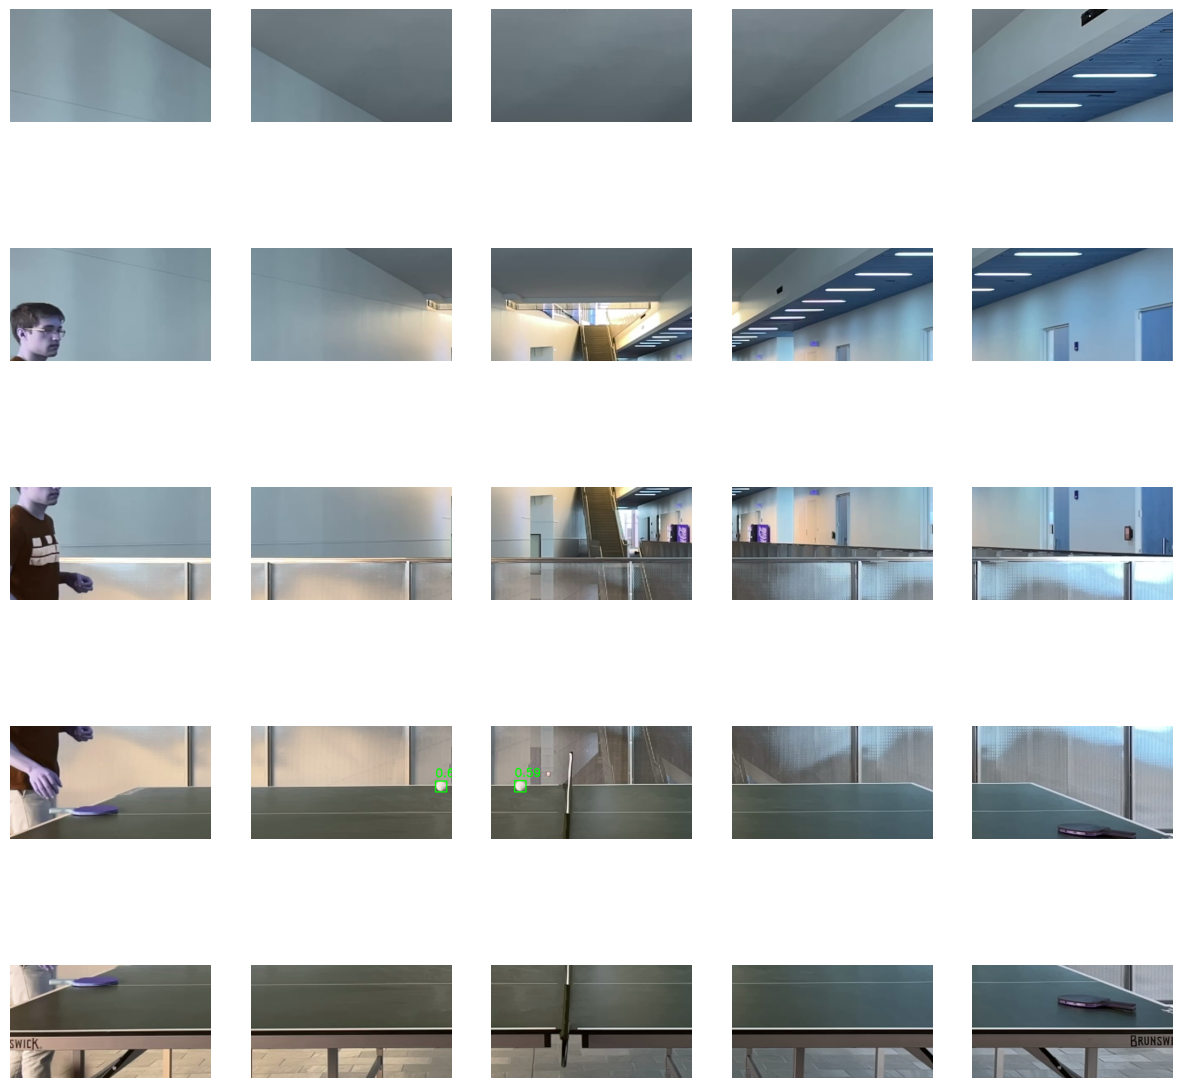

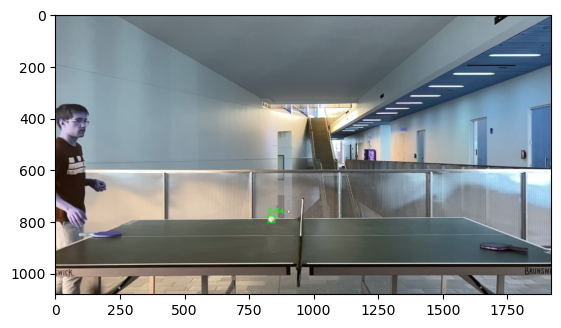

Bounding box [821, 774, 847, 800] detected with confidence 0.7269150614738464
Ball position [   -0.09942    -0.79189     0.31384] at time 0.03755868544600939


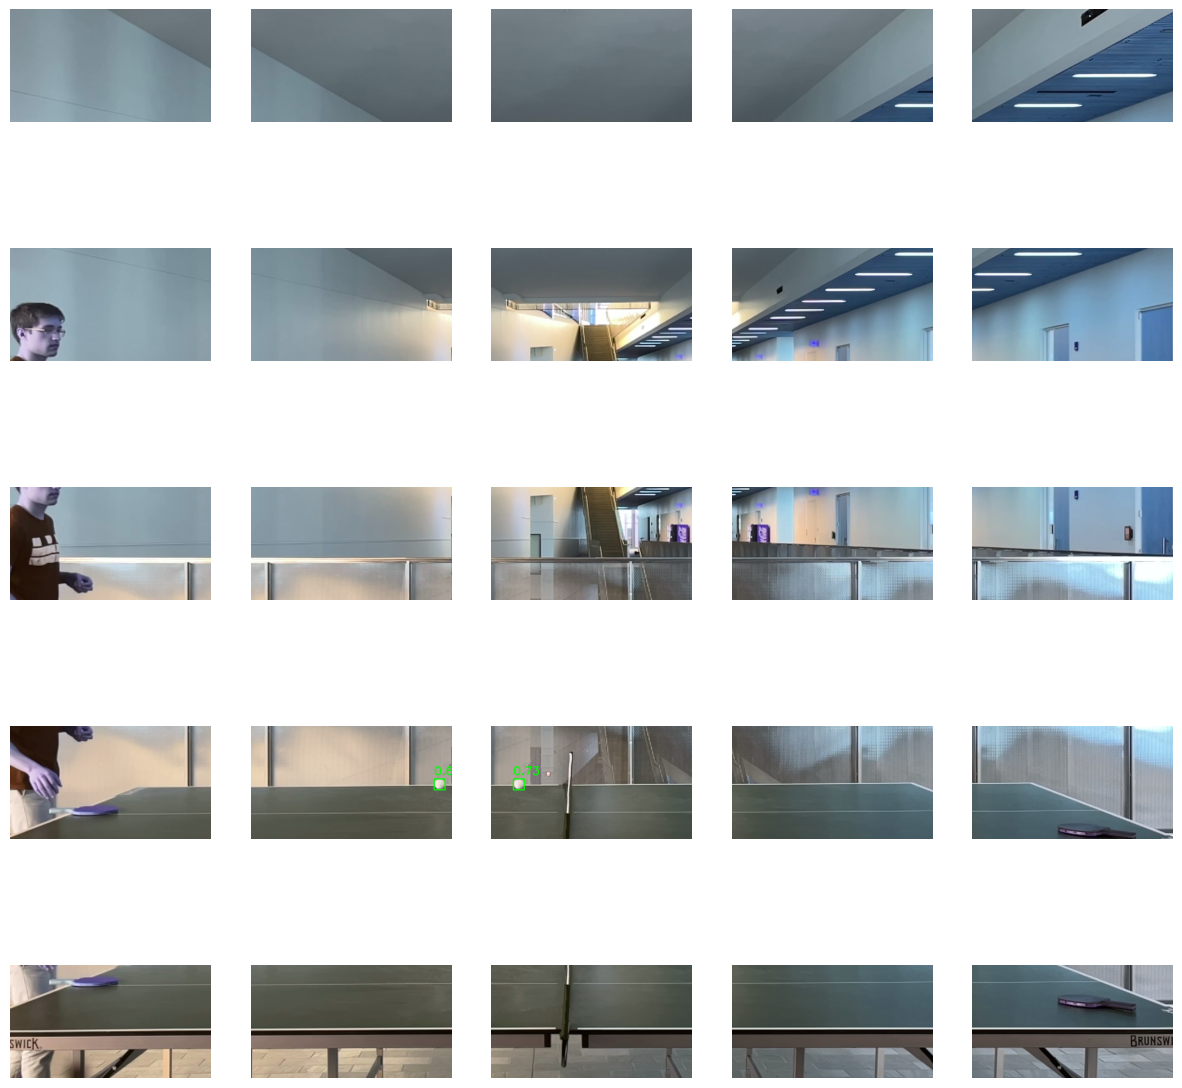

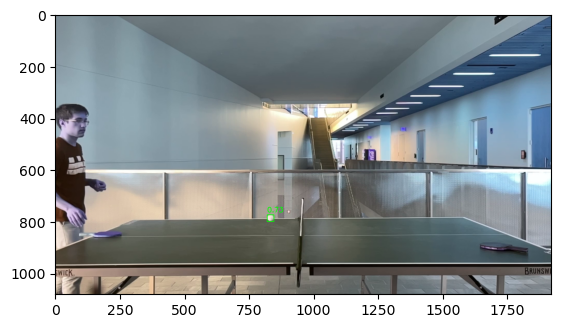

Bounding box [817, 770, 842, 795] detected with confidence 0.8031051754951477
Ball position [    -0.1114    -0.67017     0.31048] at time 0.07511737089201878


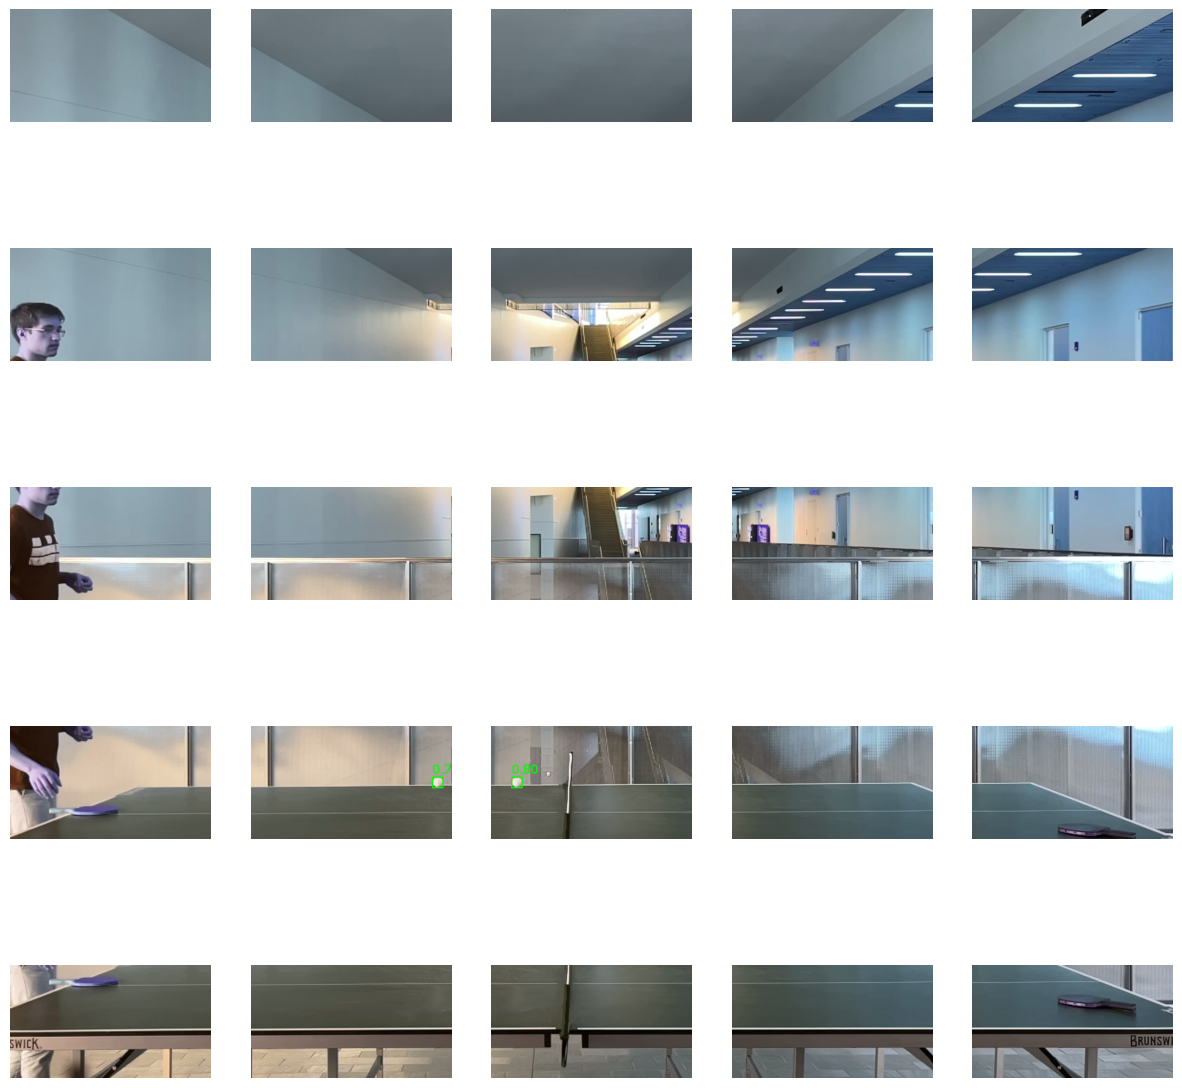

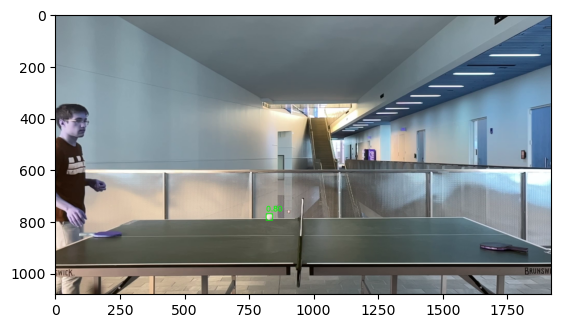

Bounding box [813, 765, 839, 788] detected with confidence 0.39700794219970703
Ball position [    -0.1263    -0.39496     0.29932] at time 0.11267605633802817


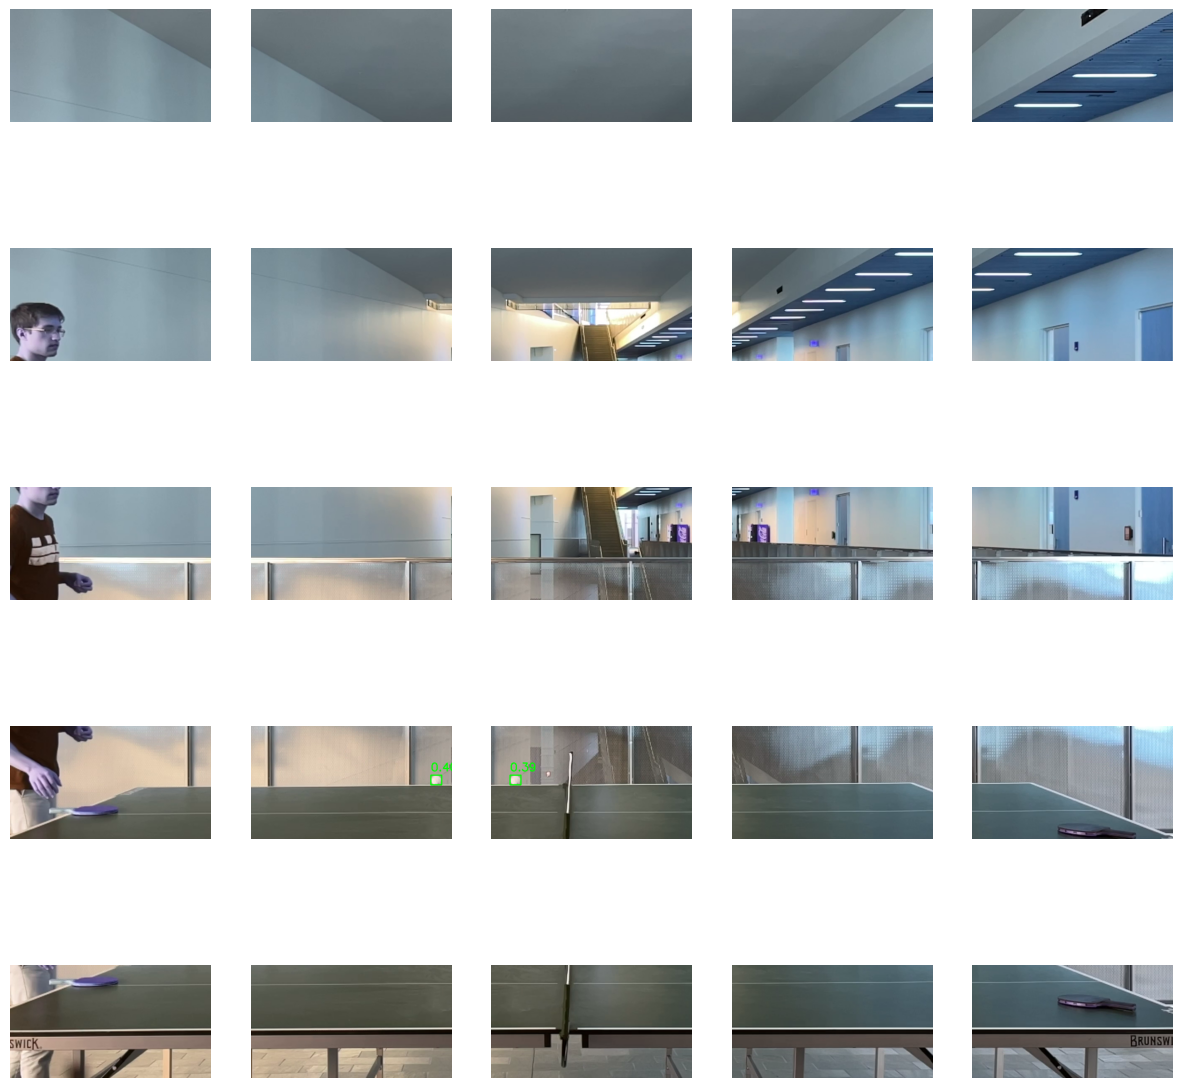

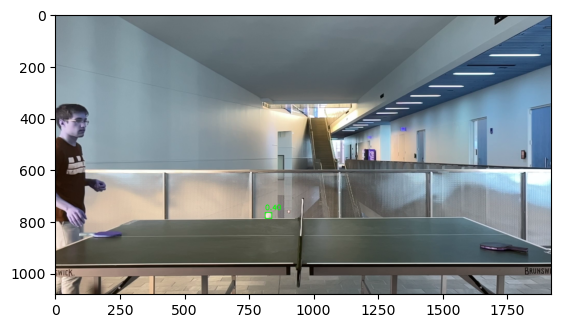

Bounding box [809, 761, 834, 786] detected with confidence 0.3567380905151367
Ball position [    -0.1242    -0.67017     0.31782] at time 0.15023474178403756


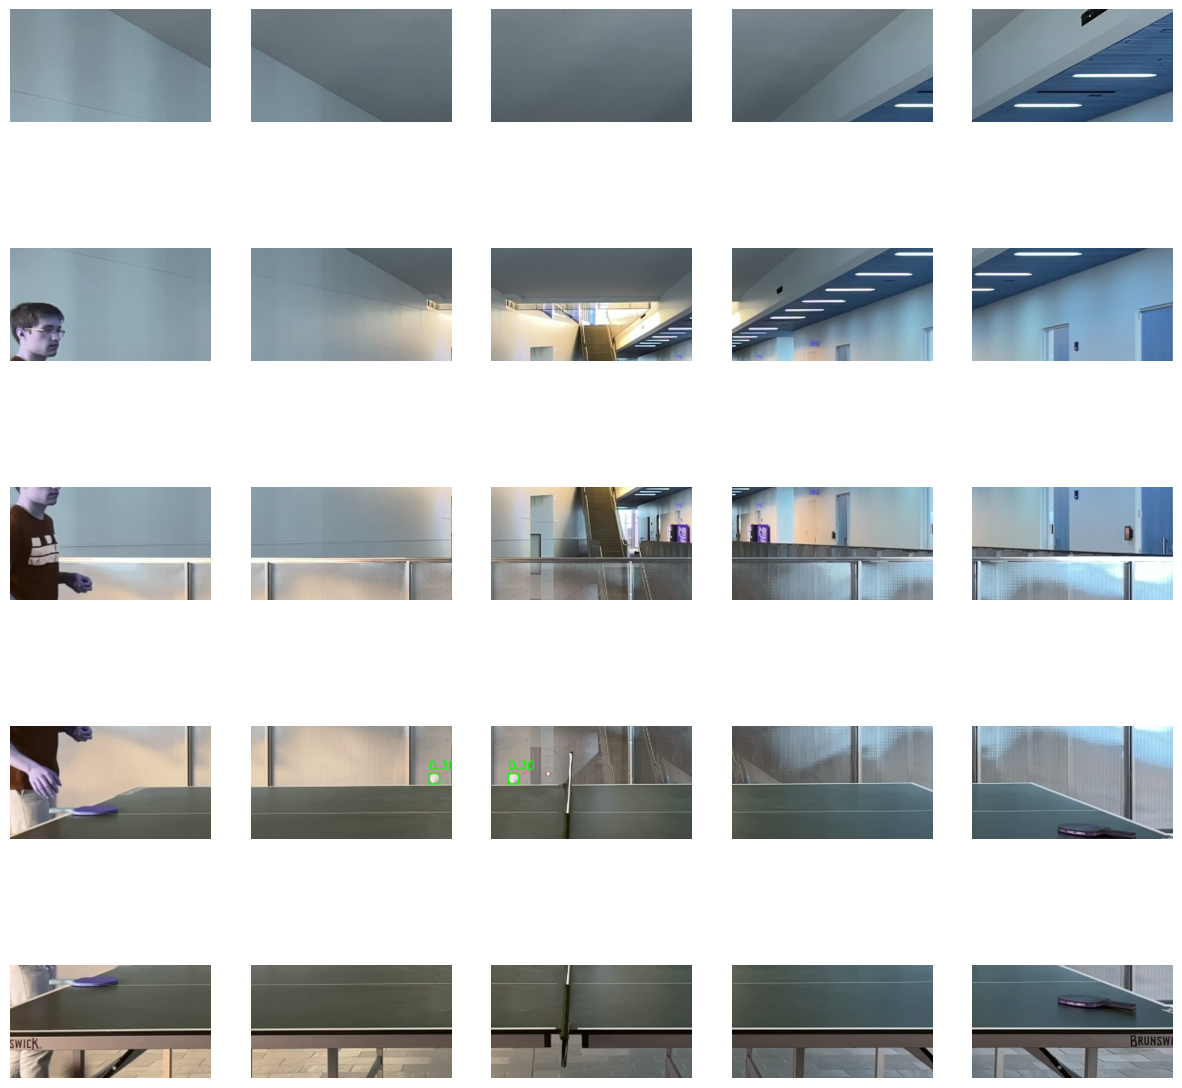

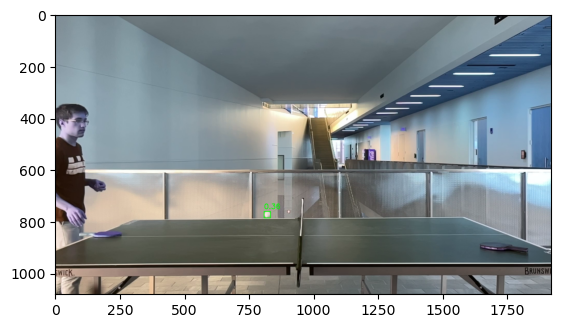

In [21]:
# Kalman Initialization Frames
n_initialization_frames = 5
initial_positions = []
initial_times = []
annotated_images = []

for i, frame in enumerate(islice(video, n_initialization_frames)):

    box, conf = detector.detect(frame, yolo_verbose = False, debug_plots = False)
    annotated_frame = frame.copy()

    if box is not None:
        print(f"Bounding box {box} detected with confidence {conf.item()}")
        detector.draw_bounding_box(annotated_frame, box, conf.item())

        center_x = (box[0] + box[2]) // 2
        center_y = (box[1] + box[3]) // 2
        diameter = min(box[2] - box[0], box[3] - box[1])

        # Get the ball position
        ball_position = position_estimator.ball_position_table_reference_frame(center_x, center_y, diameter)
        initial_positions.append(ball_position)
        initial_times.append(i * dt)
        print(f"Ball position {ball_position} at time {i * dt}")


    else:
        print("No ball detected")

    plt.figure()
    plt.imshow(annotated_frame)
    plt.show()

    annotated_images.append(annotated_frame)        

In [22]:
# Linear regression over initial positions to get initial velocity
initial_positions = np.array(initial_positions)
initial_times = np.array(initial_times)
initial_velocity = velocity_regression(initial_times, initial_positions)
print(f"Initial velocity: {initial_velocity}")

# Keep track of the states
states = [
    np.array([*initial_positions[i], *initial_velocity, 0, 0, 0, 0, 0, 0]) for i in range(len(initial_positions))
]

Initial velocity: [   -0.22808       1.705   0.0034482]


In [23]:
# Initialize Kalman Filter

# Measurement noise is in units of pixels
measurement_noise = np.eye(3) * 2
measurement_mode = PixelPositionMeasurementMode(measurement_noise, position_estimator)

initial_state = states[-1]
initial_covariance = np.eye(12) * 0.1

# Process noise should be relatively small
process_noise = np.eye(12) * 0.01

ukf = BallUKF(BALL, initial_state, initial_covariance, process_noise, measurement_mode)

Predicted State
 [    -0.1242    -0.67017     0.31782    -0.22808       1.705   0.0034482           0           0    -0.36845           0           0           0]
Mu of transformed region
 [        821         773          25]
Covariance of transformed region
 [[      43233     -133.33 -6.5777e-22]
 [    -133.33  1.6387e+05  4.6809e-22]
 [-6.5835e-22  4.6836e-22  8.5766e-23]]
Lower Bound (2 STD) 
 [405 -37  25]
Upper Bound (2 STD) 
 [1237 1583   25]
predicted_projection (821, 773, 25)


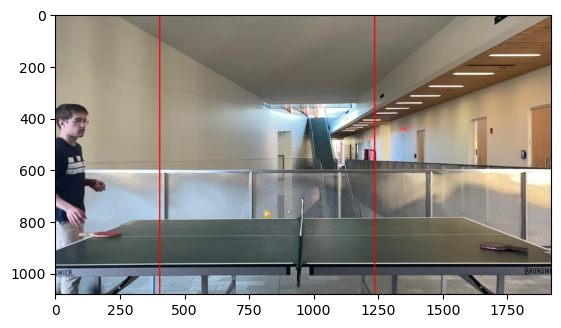

Predicted State
 [    -0.1242    -0.67017     0.30398    -0.22808       1.705   0.0034482  6.7085e-19 -3.1984e-18    -0.73866           0           0           0]
Mu of transformed region
 [     804.33         790          25]
Covariance of transformed region
 [[      48769        -250  2.3104e-10]
 [       -250  1.8337e+05 -1.3496e-21]
 [ 2.3104e-10   -1.35e-21  8.5766e-23]]
Lower Bound (2 STD) 
 [363 -66  25]
Upper Bound (2 STD) 
 [1246 1646   25]
predicted_projection (821, 790, 25)


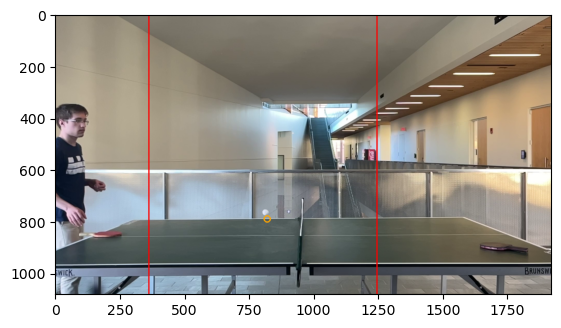

Predicted State
 [    -0.1242    -0.67017     0.27624    -0.22808       1.705   0.0034482 -6.5327e-17  9.2396e-17      -1.111           0           0  1.1811e-16]
Mu of transformed region
 [        821         824      41.667]
Covariance of transformed region
 [[      50833     -333.33     -33.333]
 [    -333.33  1.9847e+05      83.333]
 [    -33.333      83.333      569.44]]
Lower Bound (2 STD) 
 [370 -67  -6]
Upper Bound (2 STD) 
 [1272 1715   89]
predicted_projection (821, 824, 25)


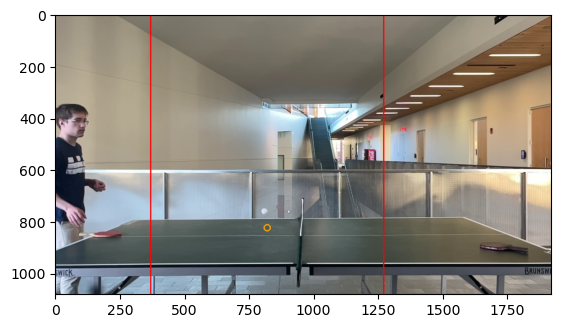

Predicted State
 [    -0.1242    -0.67017     0.23451    -0.22808       1.705   0.0034482 -1.4761e-16  1.2873e-16     -1.4869           0           0  7.8367e-15]
Mu of transformed region
 [        821         875          25]
Covariance of transformed region
 [[      56167     -466.67     -66.667]
 [    -466.67  2.1497e+05      233.33]
 [    -66.667      233.33      33.333]]
Lower Bound (2 STD) 
 [347 -52  13]
Upper Bound (2 STD) 
 [1295 1802   37]
predicted_projection (821, 875, 25)


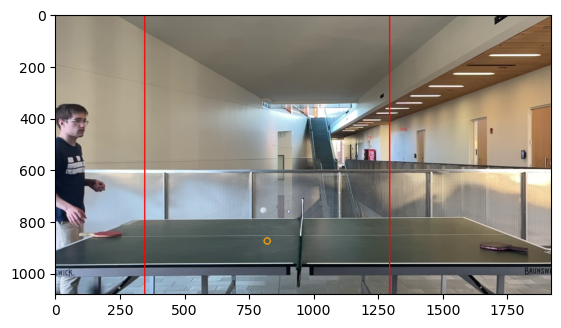

Predicted State
 [    -0.1242    -0.67017     0.17867    -0.22808       1.705   0.0034482  -3.618e-16  1.8247e-16     -1.8677           0           0           0]
Mu of transformed region
 [        821      976.33          25]
Covariance of transformed region
 [[      58933     -566.67     -66.667]
 [    -566.67  2.3704e+05      283.33]
 [    -66.667      283.33      33.333]]
Lower Bound (2 STD) 
 [335   3  13]
Upper Bound (2 STD) 
 [1307 1950   37]
predicted_projection (821, 943, 25)


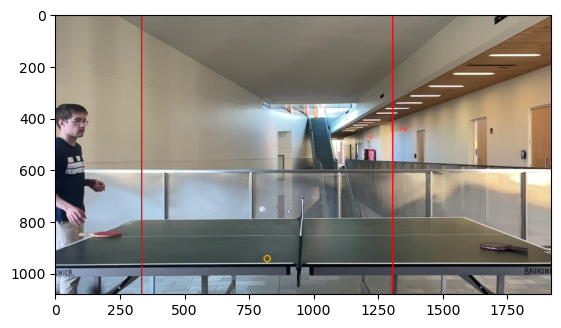

Predicted State
 [    -0.1242    -0.67017     0.10852    -0.22808       1.705   0.0034482 -3.6693e-17 -2.8152e-16      -2.255           0           0           0]
Mu of transformed region
 [        821      1062.3          25]
Covariance of transformed region
 [[      64667        -700     -66.667]
 [       -700  2.5531e+05         350]
 [    -66.667         350      33.333]]
Lower Bound (2 STD) 
 [312  52  13]
Upper Bound (2 STD) 
 [1330 2073   37]
predicted_projection (821, 1029, 25)


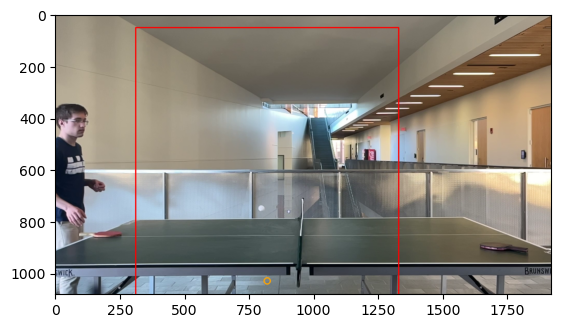

Predicted State
 [    -0.1242    -0.67017    0.023827    -0.22808       1.705   0.0034482  -2.753e-16  2.1414e-19     -2.6503           0           0           0]
Mu of transformed region
 [        821      1149.7          25]
Covariance of transformed region
 [[      70667        -900     -66.667]
 [       -900  2.7664e+05         450]
 [    -66.667         450      33.333]]
Lower Bound (2 STD) 
 [289  98  13]
Upper Bound (2 STD) 
 [1353 2202   37]
predicted_projection (821, 1133, 25)


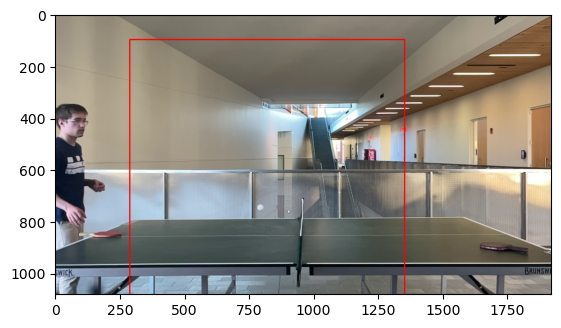

Predicted State
 [    -0.1242    -0.67017   -0.075715    -0.22808       1.705   0.0034482 -6.0541e-16  6.2789e-17     -3.0554           0           0           0]
Mu of transformed region
 [        821      1271.7          25]
Covariance of transformed region
 [[      73767       -1100     -66.667]
 [      -1100  2.9794e+05         550]
 [    -66.667         550      33.333]]
Lower Bound (2 STD) 
 [278 180  13]
Upper Bound (2 STD) 
 [1364 2363   37]
predicted_projection (821, 1255, 25)


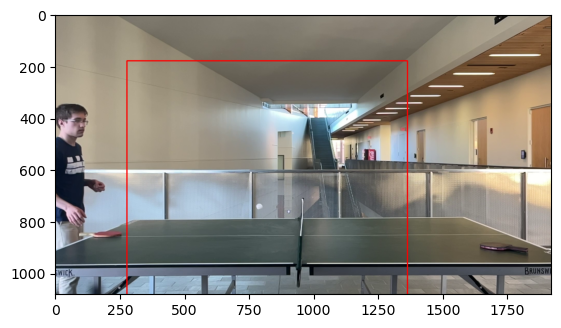

Predicted State
 [    -0.1242    -0.67017    -0.19047    -0.22808       1.705   0.0034482 -5.9608e-16  2.4861e-16     -3.4721           0           0           0]
Mu of transformed region
 [        821      1379.3          25]
Covariance of transformed region
 [[      80167       -1400     -66.667]
 [      -1400  3.2567e+05         700]
 [    -66.667         700      33.333]]
Lower Bound (2 STD) 
 [255 238  13]
Upper Bound (2 STD) 
 [1387 2521   37]
predicted_projection (821, 1396, 25)


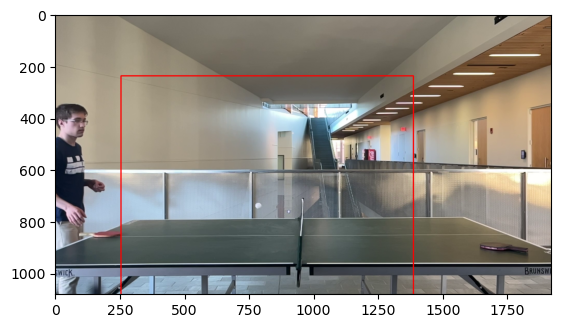

Predicted State
 [    -0.1242    -0.67017    -0.32088    -0.22808       1.705   0.0034482 -6.2822e-16 -1.5835e-17     -3.9024           0           0           0]
Mu of transformed region
 [        821        1605          25]
Covariance of transformed region
 [[      86833     -1733.3     -66.667]
 [    -1733.3  3.5756e+05      866.67]
 [    -66.667      866.67      33.333]]
Lower Bound (2 STD) 
 [232 409  13]
Upper Bound (2 STD) 
 [1410 2801   37]
predicted_projection (821, 1555, 25)
Bounding box [763, 716, 788, 741] detected with confidence 0.27677565813064575


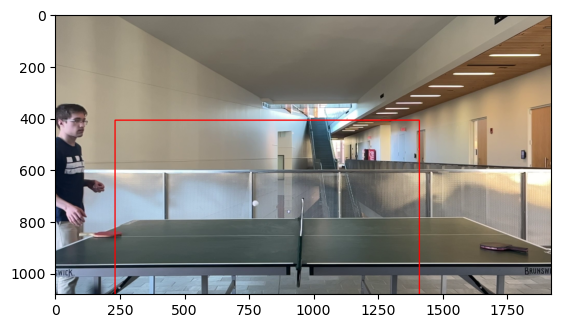

Predicted State
 [   -0.19949     -0.6644     0.24519    -0.22808       1.705   0.0034482   -0.022211   0.0086675     -4.1174  1.5729e-05   1.883e-05           0]
Mu of transformed region
 [     790.67      894.33          25]
Covariance of transformed region
 [[     8602.8      1088.9 -2.3104e-10]
 [     1088.9       37444 -4.6208e-10]
 [-2.3104e-10 -4.6208e-10  8.5766e-23]]
Lower Bound (2 STD) 
 [605 507  25]
Upper Bound (2 STD) 
 [ 976 1281   25]
predicted_projection (774, 861, 25)


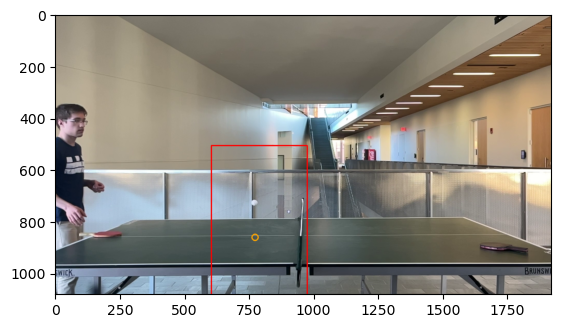

Predicted State
 [   -0.20033    -0.66407    0.090549    -0.22808       1.705   0.0034482   -0.022676   0.0088533     -4.5723  1.5729e-05   1.883e-05           0]
Mu of transformed region
 [     757.33      1083.3          25]
Covariance of transformed region
 [[      12669     -1288.9  2.3104e-10]
 [    -1288.9       54644 -4.6208e-10]
 [ 2.3104e-10 -4.6208e-10  8.5766e-23]]
Lower Bound (2 STD) 
 [532 616  25]
Upper Bound (2 STD) 
 [ 982 1551   25]
predicted_projection (774, 1050, 25)
Bounding box [755, 713, 780, 738] detected with confidence 0.27470389008522034


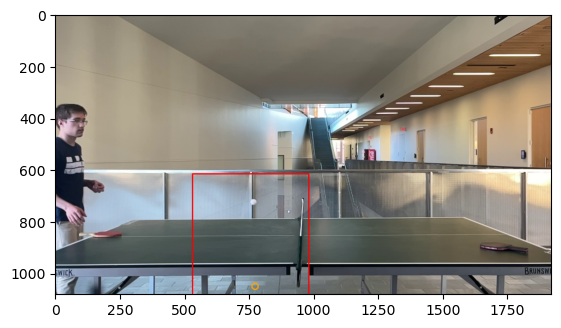

Predicted State
 [   -0.21668    -0.64451     0.18762    -0.22806       1.705   0.0034482   -0.035202    0.017493      -4.796  5.5004e-05  5.3856e-05 -3.3742e-08]
Mu of transformed region
 [     797.33         979      8.3333]
Covariance of transformed region
 [[      11378      233.33     -1138.9]
 [     233.33       41292     -1641.7]
 [    -1138.9     -1641.7      569.44]]
Lower Bound (2 STD) 
 [584 573 -39]
Upper Bound (2 STD) 
 [1011 1385   56]
predicted_projection (764, 929, 25)
Bounding box [751, 710, 777, 736] detected with confidence 0.3711805045604706


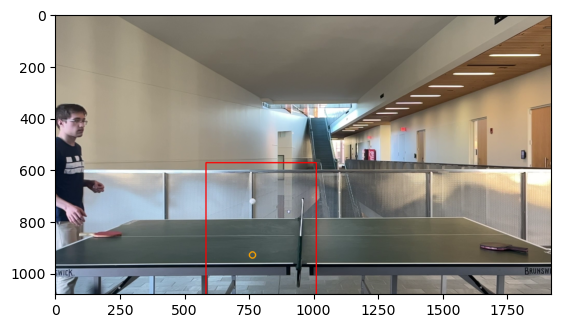

Predicted State
 [    -0.1974    -0.63579     0.16157    -0.22805       1.705   0.0034481   -0.023961     0.02509     -5.1218  8.8381e-05  3.4744e-05 -8.9537e-08]
Mu of transformed region
 [     743.67         960      8.3333]
Covariance of transformed region
 [[      11378        2100      1088.9]
 [       2100       34800      33.333]
 [     1088.9      33.333      569.44]]
Lower Bound (2 STD) 
 [530 587 -39]
Upper Bound (2 STD) 
 [ 957 1333   56]
predicted_projection (777, 960, 25)


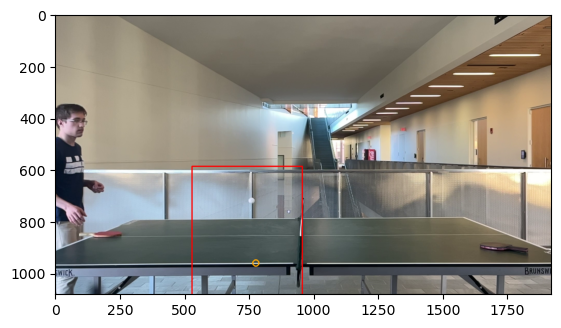

Predicted State
 [    -0.1983    -0.63485   -0.030799    -0.22805       1.705   0.0034481   -0.024572    0.025753     -5.6232  8.8381e-05  3.4744e-05 -8.9537e-08]
Mu of transformed region
 [        776        1193      8.3333]
Covariance of transformed region
 [[      13467      2266.7     -33.333]
 [     2266.7       52433         100]
 [    -33.333         100      569.44]]
Lower Bound (2 STD) 
 [544 735 -39]
Upper Bound (2 STD) 
 [1008 1651   56]
predicted_projection (776, 1193, 25)


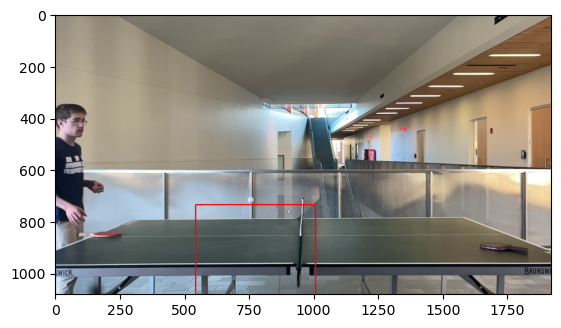

Predicted State
 [   -0.19922    -0.63388      -0.242    -0.22804       1.705   0.0034481   -0.025259    0.026498     -6.1517  8.8381e-05  3.4744e-05 -8.9537e-08]
Mu of transformed region
 [     742.67        1498      8.3333]
Covariance of transformed region
 [[      20844       -1550      1072.2]
 [      -1550       78825       -1475]
 [     1072.2       -1475      569.44]]
Lower Bound (2 STD) 
 [454 936 -39]
Upper Bound (2 STD) 
 [1031 2060   56]
predicted_projection (776, 1448, 25)


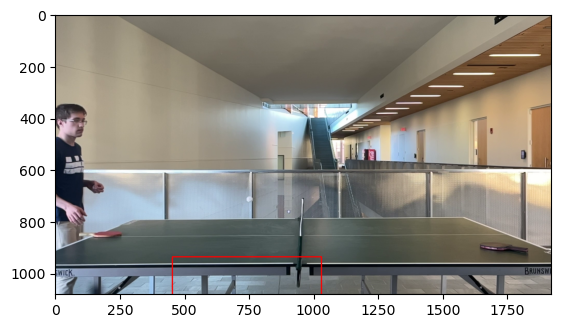

Predicted State
 [   -0.20017    -0.63289    -0.47305    -0.22804       1.705   0.0034481   -0.026031    0.027336     -6.7114  8.8381e-05  3.4744e-05 -8.9537e-08]
Mu of transformed region
 [        775      1744.7      8.3333]
Covariance of transformed region
 [[      22667        2300     -33.333]
 [       2300  1.0144e+05     -269.44]
 [    -33.333     -269.44      569.44]]
Lower Bound (2 STD) 
 [ 474 1108  -39]
Upper Bound (2 STD) 
 [1076 2382   56]
predicted_projection (775, 1728, 25)


ZeroDivisionError: division by zero

In [24]:
for i, frame in enumerate(video):

    annotated_image = frame.copy()

    # Get the high probability region in which we can find the ball    
    ukf.predict(dt)
    predicted_state = ukf.state
    lower, upper, mu, cov = ukf.get_high_likelihood_measurement_region(n_std_devs=2)
    lower, upper = np.round(lower, 0).astype(np.int64), np.round(upper, 0).astype(np.int64)

    print("Predicted State\n", predicted_state)
    print("Mu of transformed region\n", mu)
    print("Covariance of transformed region\n", cov)
    print("Lower Bound (2 STD) \n", lower)
    print("Upper Bound (2 STD) \n", upper)

    # Draw the ball's predicted position in orange
    predicted_projection = position_estimator.project_ball_position_table_reference_frame_to_camera_plane(predicted_state[:3])
    annotated_image = cv2.circle(annotated_image, (int(predicted_projection[0]), int(predicted_projection[1])), predicted_projection[2]//2, (0, 165, 255), 4)

    print("predicted_projection", predicted_projection)

    # Draw the likely region in red
    annotated_image = cv2.rectangle(annotated_image, lower[:2], upper[:2], (0, 0, 255), 4)

    # Crop to likely region and detect
    cropped_frame = crop_image_xy(frame, lower, upper)
    box, conf = detector.detect_in_split(cropped_frame, split_image_x=lower[0], split_image_y=lower[1])
    annotated_frame = frame.copy()

    if box is not None:
        print(f"Bounding box {box} detected with confidence {conf.item()}")
        detector.draw_bounding_box(annotated_frame, box, conf.item())

        center_x = (box[0] + box[2]) // 2
        center_y = (box[1] + box[3]) // 2
        diameter = min(box[2] - box[0], box[3] - box[1])

        # Since we are using the PixelPositionMeasurementMode, we only need to provide pixel coordinates
        ukf.update(np.array([center_x, center_y, diameter]))

    
    plt.figure()
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.show()

    states.append(ukf.state)
    annotated_images.append(annotated_image)


In [ ]:
print(ukf.state)
print(ukf.state_covariance)

# Check symmetric positive definite
print(np.min(np.linalg.eigvals(ukf.state_covariance)))


[    -1.7193      4.3856    -0.14956     -3.1416     -3.1416      3.1416    -0.34543      0.7042     -3.9409  0.00010027  8.2146e-05 -2.4665e-13]
[[    0.54746 -2.4652e-05   0.0043282      13.054      13.054      13.053     0.28413  -0.0005414   0.0010828 -1.2545e-07 -0.00044819 -5.2275e-05]
 [-2.4652e-05     0.60795   -0.011469     -13.836     -11.933      13.831 -0.00071134     0.36068  -0.0082707  0.00049149  1.4251e-07 -2.5648e-05]
 [  0.0043282   -0.011469       0.548     -12.679     -12.711      10.913    0.003355   -0.018199      0.3241  4.3788e-05   2.491e-05  1.3275e-11]
 [     13.054     -13.836     -12.679     -12.575      3935.5     -2974.7      33.507     -36.714     -13.506     -29.801   -0.065838       -6.01]
 [     13.054     -11.933     -12.711      3935.5     -12.574      2974.7      29.313      23.588     -58.602       30.31     -29.796      5.9922]
 [     13.053      13.831      10.913     -2974.7      2974.7     -12.566      34.094      27.581      4.8116     -30.2

In [ ]:
# Save the annotated images as a video
output_path = DATA_DIR / "output" / "annotated_ukf.mp4"
writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), video.fps, (video.width, video.height))
for image in annotated_images:
    writer.write(image)
writer.release()